In [1]:
import torch
import scipy.io
import mne
import sklearn
import os 
import random
import scipy.linalg

import pytorch_lightning as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

from itertools import chain, product

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne_features.feature_extraction import FeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import norm, wasserstein_distance
from fitter import Fitter, get_common_distributions, get_distributions

# Load the TensorBoard notebook extension
%load_ext tensorboard

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\mne_features\mock_numba.py:12: UserWarning: Numba needs NumPy 1.22 or less. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [2]:
# Import Utility functions frmo diffrent notebooks
import import_ipynb
from IEEE_data import extract_ieee_data, LazyProperty, data_4class
from CHIST_ERA_data import *
from Utils import *

importing Jupyter notebook from IEEE_data.ipynb
importing Jupyter notebook from CHIST_ERA_data.ipynb
importing Jupyter notebook from Utils.ipynb


In [3]:
def mneFeatures(X, fs):
    selected_funcs = ['line_length', 'kurtosis', 'skewness', 'pow_freq_bands', 'spect_slope',
                     'spect_entropy', 'spect_edge_freq', 'mean', 'variance', 'ptp_amp']
    params = {'pow_freq_bands__freq_bands' : np.array([[8, 10],
                                                      [10,12],
                                                      [9, 13],
                                                      [12, 20],
                                                      [20, 25],
                                                      [25, 30]])}
    fe = FeatureExtractor(sfreq=fs, selected_funcs=selected_funcs, params=params)

    X_features = fe.fit_transform(X)
    return X_features

In [4]:
class CSP:
    def __init__(self,m_filters):
        self.m_filters = m_filters

    def fit(self,x_train,y_train):
        x_data = np.copy(x_train)
        y_labels = np.copy(y_train)
        n_trials, n_channels, n_samples = x_data.shape
        cov_x = np.zeros((2, n_channels, n_channels), dtype=np.float64)
        for i in range(n_trials):
            x_trial = x_data[i, :, :]
            y_trial = y_labels[i]
            cov_x_trial = np.matmul(x_trial, np.transpose(x_trial))
            cov_x_trial /= np.trace(cov_x_trial)
            cov_x[y_trial, :, :] += cov_x_trial

        cov_x = np.asarray([cov_x[cls]/np.sum(y_labels==cls) for cls in range(2)])
        cov_combined = cov_x[0]+cov_x[1]
        eig_values, u_mat = scipy.linalg.eig(cov_combined,cov_x[0])
        sort_indices = np.argsort(abs(eig_values))[::-1]
        eig_values = eig_values[sort_indices]
        u_mat = u_mat[:,sort_indices]
        u_mat = np.transpose(u_mat)

        return eig_values, u_mat

    def transform(self,x_trial,eig_vectors):
        z_trial = np.matmul(eig_vectors, x_trial)
        z_trial_selected = z_trial[:self.m_filters,:]
        z_trial_selected = np.append(z_trial_selected,z_trial[-self.m_filters:,:],axis=0)
        sum_z2 = np.sum(z_trial_selected**2, axis=1)
        sum_z = np.sum(z_trial_selected, axis=1)
        var_z = (sum_z2 - (sum_z ** 2)/z_trial_selected.shape[1]) / (z_trial_selected.shape[1] - 1)
        sum_var_z = sum(var_z)
        return np.log(var_z/sum_var_z)

In [5]:
class FBCSP:
    def __init__(self,m_filters):
        self.m_filters = m_filters
        self.fbcsp_filters_multi=[]

    def fit(self,x_train_fb,y_train):
        y_classes_unique = np.unique(y_train)
        n_classes = len(y_classes_unique)
        self.csp = CSP(self.m_filters)

        def get_csp(x_train_fb, y_train_cls):
            fbcsp_filters = {}
            for j in range(x_train_fb.shape[0]):
                x_train = x_train_fb[j, :, :, :]
                eig_values, u_mat = self.csp.fit(x_train, y_train_cls)
                fbcsp_filters.update({j: {'eig_val': eig_values, 'u_mat': u_mat}})
            return fbcsp_filters

        for i in range(n_classes):
            cls_of_interest = y_classes_unique[i]
            select_class_labels = lambda cls, y_labels: [0 if y == cls else 1 for y in y_labels]
            y_train_cls = np.asarray(select_class_labels(cls_of_interest, y_train))
            fbcsp_filters=get_csp(x_train_fb,y_train_cls)
            self.fbcsp_filters_multi.append(fbcsp_filters)

    def transform(self,x_data,class_idx=0):
        n_fbanks, n_trials, n_channels, n_samples = x_data.shape
        x_features = np.zeros((n_trials,self.m_filters*2*len(x_data)),dtype=np.float64)
        for i in range(n_fbanks):
            eig_vectors = self.fbcsp_filters_multi[class_idx].get(i).get('u_mat')
            eig_values = self.fbcsp_filters_multi[class_idx].get(i).get('eig_val')
            for k in range(n_trials):
                x_trial = np.copy(x_data[i,k,:,:])
                csp_feat = self.csp.transform(x_trial,eig_vectors)
                for j in range(self.m_filters):
                    x_features[k, i * self.m_filters * 2 + (j+1) * 2 - 2]  = csp_feat[j]
                    x_features[k, i * self.m_filters * 2 + (j+1) * 2 - 1]= csp_feat[-j-1]

        return x_features

In [6]:
def csp_score(signal, labels, cv_N = 5, classifier = False):
    
    # Set verbose to 0
    mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []
    
    if classifier:
        y_pred = classifier.predict(signal)
        acc = sklearn.metrics.accuracy_score(labels, y_pred)
        return acc
    
    else:
        # Assemble a classifier
        svm = sklearn.svm.SVC()
        lda = LinearDiscriminantAnalysis()
#         lda = sklearn.ensemble.RandomForestClassifier()
        csp = mne.decoding.CSP(n_components=26, reg=None, log=False, norm_trace=True)
        # Use scikit-learn Pipeline with cross_val_score function
        clf = Pipeline([('CSP', csp), ('LDA', lda)])
#         clf = Pipeline([('CSP', csp), ('SVM', svm)])
        scores = cross_val_score(clf, signal, labels, cv=cv_N, n_jobs=1)
        clf.fit(signal, labels)
        return np.mean(scores), clf

In [7]:
def mneFeatures(X, fs):
    selected_funcs = ['line_length', 'kurtosis', 'skewness', 'pow_freq_bands']
    params = {'pow_freq_bands__freq_bands' : np.array([[8, 10],
                                                      [10,12],
                                                      [9, 13],
                                                      [12, 20],
                                                      [20, 25],
                                                      [25, 30]])}
    fe = FeatureExtractor(sfreq=fs, selected_funcs=selected_funcs, params=params)

    X_features = fe.fit_transform(X)
    return X_features

In [8]:
def mne_classifier(signal, labels, fs, zero_time, classifier = False):
    # cut signal before + after
    signal_before = signal[:, :, :fs*zero_time]
    signal_after = signal[:, :, fs*zero_time:]
    # Get features
    features_before = mneFeatures(signal_before, fs)
    features_after = mneFeatures(signal_after, fs)
    
#     X = np.hstack((features_before, features_after))
    X = np.divide(features_before, features_after)
    if classifier:
        score = features_classfier(X, labels, 5, classifier)
        return score
    else:
        score, clf = features_classfier(X, labels, 5, classifier)
    return score, clf


In [9]:
def features_classfier(X, y, cv_N = 5, classifier = False):
    
    scores = []
    
    if classifier:
        y_pred = classifier.predict(X)
        acc = sklearn.metrics.accuracy_score(y, y_pred)
        return acc
    
    else:
        # Assemble a classifier
#         clf = RandomForestClassifier()
        clf = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
        scores = cross_val_score(clf, X, y, cv=cv_N, n_jobs=1)
        clf.fit(X, y)
        return np.mean(scores), clf

In [10]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    ly += yerr[num1]
    ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh+0.05)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [11]:
def original_day_classifier(eeg_list):
    # Use day zero classifier for classifying the reconstructed eeg per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()
       
        # Get residuals
        residuals.append(signal_test.detach().numpy())
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

In [12]:
def reconstruction_day_classifier(AE_model, eeg_list):
    # Use day zero classifier for classifying the reconstructed eeg per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()

        # reconstruct EEG AE
        rec_signal = AE_model(signal_test).detach().numpy()        
        # Get residuals
        residuals.append(rec_signal)
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

In [13]:
def residual_day_classifier(AE_model, eeg_list):
    # Use day zero classifier for classifying the residuals per day
    
    residuals = []
    labels = []
    for day_i in range(len(eeg_list)):
        # Get data
        signal_test_data = EEGDataSet_signal(dictListStacked, [day_i, day_i+1])
        signal_test, y_test = signal_test_data.getAllItems()

        # reconstruct EEG AE
        rec_signal = AE_model(signal_test).detach().numpy()        
        # Get residuals
        residuals.append((signal_test - rec_signal).detach().numpy())
        labels.append(np.ones((1, signal_test.shape[0])) * day_i)
    labels= np.hstack(labels)
    labels = np.squeeze(labels)
    residuals = np.vstack(residuals)

    score, _ = csp_score(np.float64(residuals), labels, cv_N = 5, classifier = False)
    return score

### Datset and Model classes

In [14]:
class EEGDataSet_signal(Dataset):
    def __init__(self, EEGDict, days_range=[0,1]):
        
        # Concat dict      
        X, y = self.concat(EEGDict, days_range)
        

        
        # Convert from numpy to tensor
        self.X = torch.tensor(X)
        self.n_samples = self.X.shape[0]
        self.n_channels = self.X.shape[1]
        self.y = y

        
    def __getitem__(self, index):
        return self.X[index].float(), self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.X.float() , self.y
    
    def concat(self, EEGDict, days_range):
        X = []
        y = []
        for d in dictListStacked[days_range[0]:days_range[1]]:
            X.append(d['segmentedEEG'])
            y.append(d['labels'])

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.concatenate(X)
        y = np.concatenate(y)
        return X, y

In [15]:
class convolution_AE(LightningModule):
    def __init__(self, input_channels, learning_rate=1e-3, filters_n = [16, 32, 64], pca_W = False):
        super().__init__()
        self.input_channels = input_channels
        self.filters_n = filters_n
        self.learning_rate = learning_rate
        self.float()
        self.l1_filters, self.l2_filters, self.l3_filters = self.filters_n

        self.pca_W = pca_W
        ### The model architecture ###
        
        # Encoder
        self.encoder = nn.Sequential(
        nn.Conv1d(self.input_channels, self.l1_filters, kernel_size=15, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l1_filters, self.l2_filters, kernel_size=10, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l2_filters, self.l3_filters, kernel_size=5, stride=2, padding=1),
        nn.LeakyReLU()
        )
                
        # Decoder
        self.decoder = nn.Sequential(
        # IMPORTENT - on the IEEE dataset - the output padding needs to be 1 in the row below -on CHIST-ERA its 1
        nn.ConvTranspose1d(self.l3_filters, self.l2_filters, kernel_size=5, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l2_filters, self.l1_filters, kernel_size=10, stride=2, padding=1, output_padding=0),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l1_filters, self.input_channels, kernel_size=15, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        # Recountruction
        logits = self.forward(x)
        # Loss function
        try:
            if len(self.pca_W.shape)>0:
                rec_error = pca_error(self.pca_W, logits)
                loss = F.mse_loss(logits, x) + 0*rec_error
        except:
            loss = F.mse_loss(logits, x)
            
        return loss
    
        
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

# Training loop function

In [16]:
def training_loop(train_days, dictListStacked, fs, ae_learning_rt, convolution_filters, batch_sz, zero_time, epoch_n):
    

    # Logger
    logger = TensorBoardLogger('tb_logs', name='EEG_Logger')

    # Train Dataset
    signal_data = EEGDataSet_signal(dictListStacked, train_days)
    signal_data_loader = DataLoader(dataset=signal_data, batch_size=batch_sz, shuffle=True, num_workers=0)
    x, y = signal_data.getAllItems()

    # Train model on training day
    day_zero_AE = convolution_AE(signal_data.n_channels, ae_learning_rt, filters_n=convolution_filters)
    trainer_1 = pl.Trainer(max_epochs=epoch_n, gpus=0, progress_bar_refresh_rate=20, logger=logger)
    trainer_1.fit(day_zero_AE, train_dataloaders=signal_data_loader)
    
    # Day 0 classifier
#     score_ae, day_zero_AE_clf = mne_classifier(day_zero_AE(x).detach().numpy(), y, fs, zero_time, classifier = False)
#     score_bench, day_zero_bench_clf = mne_classifier(x.detach().numpy(), y, fs, zero_time, classifier = False)
#     score_ae, day_zero_AE_clf = csp_score(np.float64(day_zero_AE(x).detach().numpy()), y, cv_N = 5, classifier = False)
#     score_bench, day_zero_bench_clf = csp_score(np.float64(x.detach().numpy()), y, cv_N = 5, classifier = False)
    
    score_ae, day_zero_AE_clf = fbcsp_score(np.float64(day_zero_AE(x).detach().numpy()), y, cv_N = 5, classifier = False, fs=fs, m_filters=26)
    score_bench, day_zero_bench_clf = fbcsp_score(np.float64(x.detach().numpy()), y, cv_N = 5, classifier = False, fs=fs, m_filters=26)

    # Loop :)
    bench_diff_day_score = []
    bench_same_day_score = []
    AE_diff_day_score = []
    
    # Append day zero score
    bench_diff_day_score.append(score_bench)
    bench_same_day_score.append(score_bench)
    AE_diff_day_score.append(score_ae)

    for i in range(train_days[1], len(dictListStacked)):
        test_days = [i, i+1]

        # Create test Datasets
        signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
        signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=8, shuffle=True, num_workers=0)

        # get data
        signal_test, y_test = signal_test_data.getAllItems()
        # reconstruct EEG using day 0 AE
        rec_signal_zero = day_zero_AE(signal_test).detach().numpy()


        # Use models
        print('Day #',i)
#         same_day_score, _ = csp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = False)
#         same_day_score, _ = mne_classifier(signal_test.detach().numpy(), y_test, fs, zero_time, classifier = False)
        same_day_score, _ = fbcsp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = False, fs=fs, m_filters=26)
        print('Bench-\nIn day accuracy: ', same_day_score)
#         bench_diff_day = csp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = day_zero_bench_clf)
#         bench_diff_day  = mne_classifier(signal_test.detach().numpy(), y_test, fs, zero_time, day_zero_bench_clf)
        bench_diff_day = fbcsp_score(np.float64(signal_test.detach().numpy()), y_test, cv_N = 5, classifier = day_zero_bench_clf, fs=fs, m_filters=26)
        print('Different day accuracy: ',bench_diff_day)

#         AE_diff_day = csp_score(rec_signal_zero, y_test, cv_N = 5, classifier = day_zero_AE_clf)
#         AE_diff_day =  mne_classifier(rec_signal_zero, y_test, fs, zero_time, day_zero_AE_clf)
        AE_diff_day = fbcsp_score(rec_signal_zero, y_test, cv_N = 5, classifier = day_zero_AE_clf, fs=fs, m_filters=26)
        print('AE-\nDifferent day accuracy: ', AE_diff_day, '\n')

        # Append each day results
        AE_diff_day_score.append(AE_diff_day)
        bench_diff_day_score.append(bench_diff_day) 
        bench_same_day_score.append(same_day_score)
    
    return bench_same_day_score, bench_diff_day_score, AE_diff_day_score, day_zero_AE

### Load the files - IEEE

In [22]:
tmin = 0
tmax = 6
select_label = [1,4]
zero_time = 2

filterLim = [4,40] # In Hz
batch_sz = 16
fs = 500
ae_learning_rt = 1e-3
n_epochs = 250
batch_sz = 16
convolution_filters = [8,16,32]

amp_thresh = 250
min_trials = 10

In [23]:
# del dictListStacked

In [24]:
sub = 'A3'

try:
    assert dictListStacked[0]['sub'] == sub
except:
    dictListStacked = extract_ieee_data(sub, filterLim, tmin, tmax, select_label, data_dir = 'data/ieee_dataset/')

In [25]:

# Remove noisy trials using amplitude threshold
new_dict_list = []
for i, D in enumerate(dictListStacked):
    max_amp = np.amax(np.amax(D['segmentedEEG'], 2), 1)
    min_amp = np.amin(np.amin(D['segmentedEEG'], 2), 1)
    max_tr = max_amp > amp_thresh 
    min_tr = min_amp < -amp_thresh
    noisy_trials = [a or b for a, b in zip(max_tr, min_tr)]
    D['segmentedEEG'] = np.delete(D['segmentedEEG'], noisy_trials,axis=0)
    D['labels'] = np.delete(D['labels'], noisy_trials,axis=0)
    if D['segmentedEEG'].shape[0] > min_trials:
            new_dict_list.append(D)

dictListStacked = new_dict_list


# Run training

In [26]:
# Sub 206 - 200 epochs
train_days=[0,1]

bench_same_day_score, bench_diff_day_score, AE_diff_day_score, _ = \
training_loop(train_days, dictListStacked, fs, ae_learning_rt, convolution_filters, batch_sz, zero_time, n_epochs)

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(96, 468) tr
(96, 160) tr
(24, 468) val
(24, 160) val
(96, 468) tr
(96, 160) tr
(24, 468) val
(24, 160) val
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
(96, 468) tr
(96, 160) tr
(24, 468) val
(24, 160) val
(96, 468) tr
(96, 144) tr
(24, 468) val
(24, 144) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 180) tr
(24, 468) val
(24, 180) val
(96, 468) tr
(96, 180) tr
(24, 468) val
(24, 180) val
(96, 468) tr
(96, 180) tr
(24, 468) val
(24, 180) val
(96, 468) tr
(96, 184) tr
(24, 468) val
(24, 184) val
Day # 1
(88, 468) tr
(88, 196) tr
(23, 468) val
(23, 196) val
(89, 468) tr
(89, 192) tr
(22, 468) val
(22, 192) val
(89, 468) tr
(89, 192) tr
(22, 468) val
(22, 192) val
(89, 468) tr
(89, 192) tr
(22, 468) val
(22, 192) val
(89, 468) tr
(89, 192) tr
(22, 468) val
(22, 192) val
Bench-
In day accuracy:  0.8565217391304347
Different day accuracy:  0.5135135135135135
AE-
Different day accuracy:  0.5855855855855856 

Day # 2
(71, 468) tr
(71, 180) tr
(18, 468) 


KeyboardInterrupt



In [ ]:
# Start from which day to plot?
plot_from = 0

# Plot
plt.plot(range(plot_from, plot_from + len(AE_diff_day_score[plot_from:])), AE_diff_day_score[plot_from:], label='AE diff day', color='g')
plt.plot(range(plot_from, plot_from + len(AE_diff_day_score[plot_from:])), bench_diff_day_score[plot_from:], label='bench diff day', color='r')
plt.plot(range(plot_from, plot_from + len(AE_diff_day_score[plot_from:])), bench_same_day_score[plot_from:], label='bench same day', color='b')

plt.axhline(y=np.mean(AE_diff_day_score[plot_from:]), color='g', linestyle='--')
plt.axhline(y=np.mean(bench_diff_day_score[plot_from:]), color='r', linestyle='--')
plt.axhline(y=np.mean(bench_same_day_score[plot_from:]), color='b', linestyle='--')

plt.title('Accuracy Over Days - Using Day 0 Classifier')
plt.xlabel('Day #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loop over all files

In [27]:
# Corrupted files - A1, A4(maybe?), A5(maybe?), A8(maybe?), S1(maybe?), S4(maybe?)
sub_list = ['A2', 'A3', 'A4', 'S4', 'S5'] #['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8','S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8','S9','S10','S11', 'S12']
           

same_list = []
diff_list = []
AE_list = []
day_classification_score = []
for sub in sub_list:
    try:
        dictListStacked = extract_ieee_data(sub, filterLim, tmin, tmax, select_label, data_dir = 'data/ieee_dataset/')
    except:
        continue
    # Remove noisy trials using amplitude threshold
    new_dict_list = []
    for i, D in enumerate(dictListStacked):
        max_amp = np.amax(np.amax(D['segmentedEEG'], 2), 1)
        min_amp = np.amin(np.amin(D['segmentedEEG'], 2), 1)
        max_tr = max_amp > amp_thresh 
        min_tr = min_amp < -amp_thresh
        noisy_trials = [a or b for a, b in zip(max_tr, min_tr)]
        D['segmentedEEG'] = np.delete(D['segmentedEEG'], noisy_trials,axis=0)
        D['labels'] = np.delete(D['labels'], noisy_trials,axis=0)
        if D['segmentedEEG'].shape[0] > min_trials:
                new_dict_list.append(D)

    dictListStacked = new_dict_list
        
    train_days=[0,1]
    
    bench_same_day_score, bench_diff_day_score, AE_diff_day_score, day_zero_AE = \
    training_loop(train_days, dictListStacked, fs, ae_learning_rt, convolution_filters, batch_sz, zero_time, n_epochs)
    
    # Day classfication using residuals original and recontrusted EEG
    res_score = residual_day_classifier(day_zero_AE, dictListStacked)
    rec_score = reconstruction_day_classifier(day_zero_AE, dictListStacked)
    orig_score = original_day_classifier(dictListStacked)
    day_classification_score.append([orig_score, rec_score, res_score])
    
    # Add results
    same_list.append(bench_same_day_score)
    diff_list.append(bench_diff_day_score)
    AE_list.append(AE_diff_day_score)
    print(sub)
    print(np.mean(bench_same_day_score))
    print(np.mean(bench_diff_day_score))
    print(np.mean(AE_diff_day_score))


C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
(96, 468) tr
(96, 180) tr
(24, 468) val
(24, 180) val
(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
(96, 468) tr
(96, 188) tr
(24, 468) val
(24, 188) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 184) tr
(24, 468) val
(24, 184) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 184) tr
(24, 468) val
(24, 184) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
Day # 1
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
Bench-
In day accuracy:  0.8416666666666668
Different day accuracy:  0.5
AE-
Different day accuracy:  0.7916666666666666 

Day # 2
(96, 468) tr
(96, 156) tr
(24, 468) val
(24, 156) v

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 156) tr
(24, 468) val
(24, 156) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
(96, 468) tr
(96, 184) tr
(24, 468) val
(24, 184) val
(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
(96, 468) tr
(96, 184) tr
(24, 468) val
(24, 184) val
(96, 468) tr
(96, 188) tr
(24, 468) val
(24, 188) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
Day # 1
(88, 468) tr
(88, 188) tr
(23, 468) val
(23, 188) val
(89, 468) tr
(89, 196) tr
(22, 468) val
(22, 196) val
(89, 468) tr
(89, 192) tr
(22, 468) val
(22, 192) val
(89, 468) tr
(89, 196) tr
(22, 468) val
(22, 196) val
(89, 468) tr
(89, 200) tr
(22, 468) val
(22, 200) val
Bench-
In day accuracy:  0.8561264822134387
Different day accuracy:  0.5135135135135135
AE-
Different day accuracy:  0.5765765765765766 

Day # 2
(71, 468) tr
(71, 196) tr
(18, 468) 

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(92, 468) tr
(92, 180) tr
(23, 468) val
(23, 180) val
(92, 468) tr
(92, 172) tr
(23, 468) val
(23, 172) val
(92, 468) tr
(92, 168) tr
(23, 468) val
(23, 168) val
(92, 468) tr
(92, 180) tr
(23, 468) val
(23, 180) val
(92, 468) tr
(92, 156) tr
(23, 468) val
(23, 156) val
(92, 468) tr
(92, 160) tr
(23, 468) val
(23, 160) val
(92, 468) tr
(92, 152) tr
(23, 468) val
(23, 152) val
(92, 468) tr
(92, 164) tr
(23, 468) val
(23, 164) val
(92, 468) tr
(92, 180) tr
(23, 468) val
(23, 180) val
(92, 468) tr
(92, 152) tr
(23, 468) val
(23, 152) val
Day # 1
(95, 468) tr
(95, 144) tr
(24, 468) val
(24, 144) val
(95, 468) tr
(95, 156) tr
(24, 468) val
(24, 156) val
(95, 468) tr
(95, 160) tr
(24, 468) val
(24, 160) val
(95, 468) tr
(95, 148) tr
(24, 468) val
(24, 148) val
(96, 468) tr
(96, 144) tr
(23, 468) val
(23, 144) val
Bench-
In day accuracy:  0.722463768115942
Different day accuracy:  0.6134453781512605
AE-
Different day accuracy:  0.5126050420168067 

Day # 2
(96, 468) tr
(96, 184) tr
(24, 468) v

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(80, 468) tr
(80, 180) tr
(20, 468) val
(20, 180) val
(80, 468) tr
(80, 168) tr
(20, 468) val
(20, 168) val
(80, 468) tr
(80, 180) tr
(20, 468) val
(20, 180) val
(80, 468) tr
(80, 180) tr
(20, 468) val
(20, 180) val
(80, 468) tr
(80, 160) tr
(20, 468) val
(20, 160) val
(80, 468) tr
(80, 160) tr
(20, 468) val
(20, 160) val
(80, 468) tr
(80, 140) tr
(20, 468) val
(20, 140) val
(80, 468) tr
(80, 140) tr
(20, 468) val
(20, 140) val
(80, 468) tr
(80, 152) tr
(20, 468) val
(20, 152) val
(80, 468) tr
(80, 172) tr
(20, 468) val
(20, 172) val
Day # 1
(93, 468) tr
(93, 160) tr
(24, 468) val
(24, 160) val
(93, 468) tr
(93, 152) tr
(24, 468) val
(24, 152) val
(94, 468) tr
(94, 152) tr
(23, 468) val
(23, 152) val
(94, 468) tr
(94, 164) tr
(23, 468) val
(23, 164) val
(94, 468) tr
(94, 148) tr
(23, 468) val
(23, 148) val
Bench-
In day accuracy:  0.4192028985507246
Different day accuracy:  0.5299145299145299
AE-
Different day accuracy:  0.5641025641025641 

Day # 2
(77, 468) tr
(77, 164) tr
(20, 468) 

C:\Users\ofera\anaconda3\envs\rehab\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.0 K 
1 | decoder | Sequential | 7.0 K 
---------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
C:\Users\ofera\anaconda3\envs\rehab\lib\site

Training: 0it [00:00, ?it/s]

(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 144) tr
(24, 468) val
(24, 144) val
(96, 468) tr
(96, 172) tr
(24, 468) val
(24, 172) val
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 176) tr
(24, 468) val
(24, 176) val
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
(96, 468) tr
(96, 168) tr
(24, 468) val
(24, 168) val
(96, 468) tr
(96, 164) tr
(24, 468) val
(24, 164) val
Day # 1
(81, 468) tr
(81, 180) tr
(21, 468) val
(21, 180) val
(81, 468) tr
(81, 172) tr
(21, 468) val
(21, 172) val
(82, 468) tr
(82, 180) tr
(20, 468) val
(20, 180) val
(82, 468) tr
(82, 184) tr
(20, 468) val
(20, 184) val
(82, 468) tr
(82, 184) tr
(20, 468) val
(20, 184) val
Bench-
In day accuracy:  0.7547619047619047
Different day accuracy:  0.5098039215686274
AE-
Different day accuracy:  0.6176470588235294 

Day # 2
(95, 468) tr
(95, 164) tr
(24, 468) 

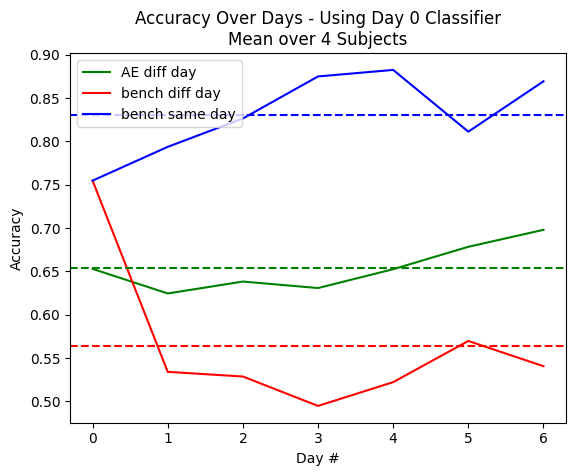

In [28]:
ok_same = []
ok_diff = []
ok_AE = []

for i in range(len(diff_list)):
    if np.mean(same_list[i]) > 0.1:
        
        if len(same_list[i]) < 7:
            continue
        ok_same.append(np.asarray(same_list[i][:]))
        ok_diff.append(np.asarray(diff_list[i][:]))
        ok_AE.append(np.asarray(AE_list[i][:]))

sub_N = len(ok_same)        
ok_same = np.mean(np.vstack(ok_same), axis = 0)
ok_diff = np.mean(np.vstack(ok_diff), axis = 0)
ok_AE = np.mean(np.vstack(ok_AE), axis = 0)


# Start from which day to plot?
plot_from = 0

# Plot
plt.plot(range(plot_from, plot_from + len(ok_diff[plot_from:])), ok_AE[plot_from:], label='AE diff day', color='g')
plt.plot(range(plot_from, plot_from + len(ok_diff[plot_from:])), ok_diff[plot_from:], label='bench diff day', color='r')
plt.plot(range(plot_from, plot_from + len(ok_diff[plot_from:])), ok_same[plot_from:], label='bench same day', color='b')

plt.axhline(y=np.mean(ok_AE[plot_from:]), color='g', linestyle='--')
plt.axhline(y=np.mean(ok_diff[plot_from:]), color='r', linestyle='--')
plt.axhline(y=np.mean(ok_same[plot_from:]), color='b', linestyle='--')

plt.title(f'Accuracy Over Days - Using Day 0 Classifier\nMean over {sub_N} Subjects')
plt.xlabel('Day #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
_, p_01 = scipy.stats.ttest_ind(np.vstack(day_classification_score)[:,1],np.vstack(day_classification_score)[:,0])
_, p_12 = scipy.stats.ttest_ind(np.vstack(day_classification_score)[:,1],np.vstack(day_classification_score)[:,2])
_, p_02 = scipy.stats.ttest_ind(np.vstack(day_classification_score)[:,2],np.vstack(day_classification_score)[:,0])


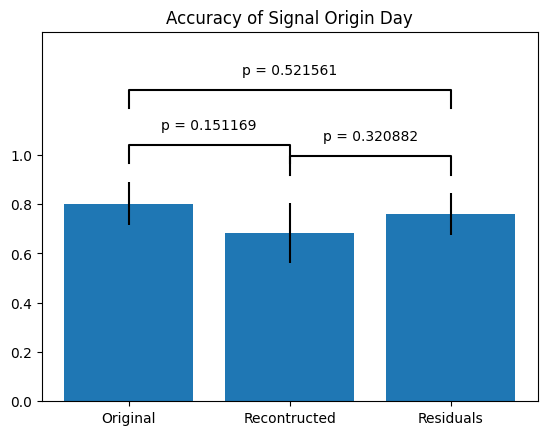

In [37]:
heights = days_classification_mean
bars = np.arange(len(heights))

plt.figure()
plt.bar(bars, heights, align='center', yerr=days_classification_std)
plt.ylim(0, 1.5)
barplot_annotate_brackets(0, 1, f'p = {np.round(p_01,decimals=6)}', bars, heights, yerr=days_classification_std)
barplot_annotate_brackets(1, 2, f'p = {np.round(p_12,decimals=6)}', bars, heights, yerr=days_classification_std)
barplot_annotate_brackets(0, 2, f'p = {np.round(p_02,decimals=6)}', bars, heights, dh=.2, yerr=days_classification_std)
plt.xticks(ticks=bars, labels=['Original', 'Recontructed', 'Residuals'])
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.title('Accuracy of Signal Origin Day')
plt.show()

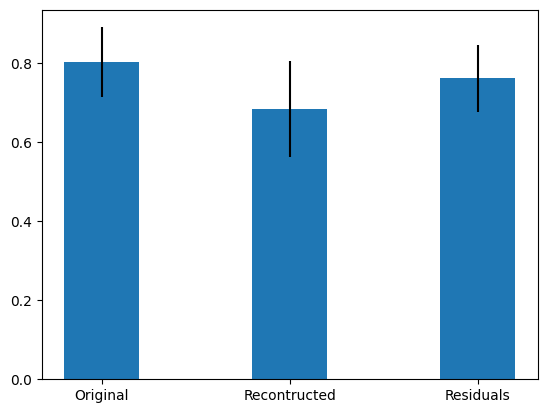

In [36]:
days_classification_mean = np.mean(np.vstack(day_classification_score), axis = 0)
days_classification_std = np.std(np.vstack(day_classification_score), axis = 0)
plt.figure()

plt.bar([2,4,6], days_classification_mean, width=0.8, align='center', tick_label=['Original', 'Recontructed', 'Residuals'],\
    yerr=days_classification_std)
plt.show()

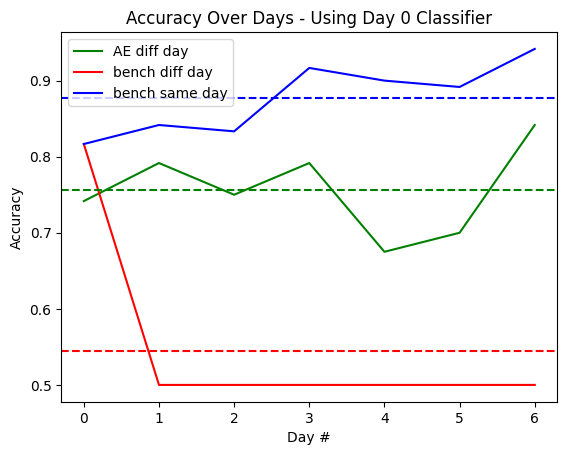

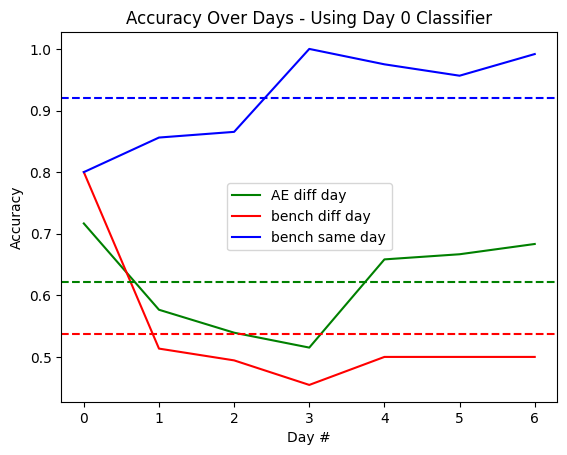

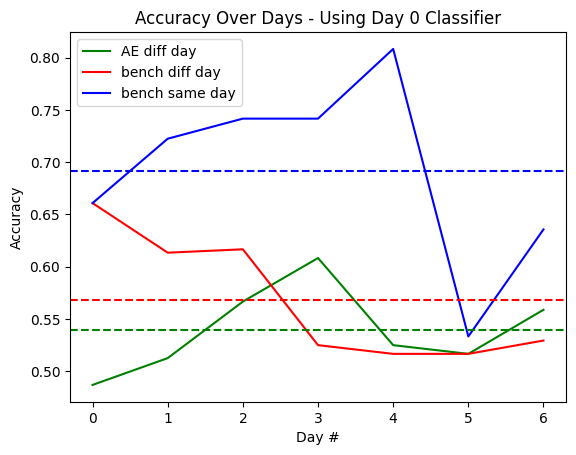

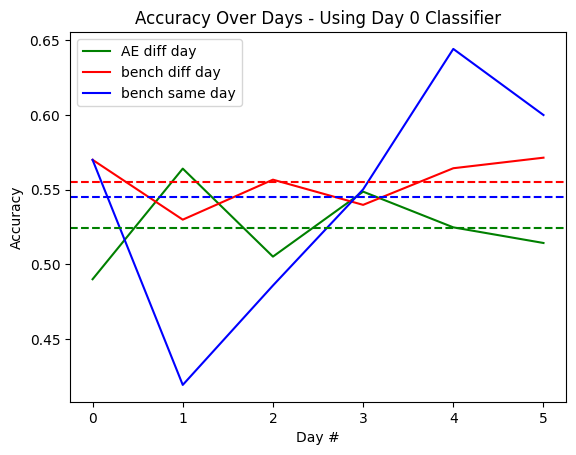

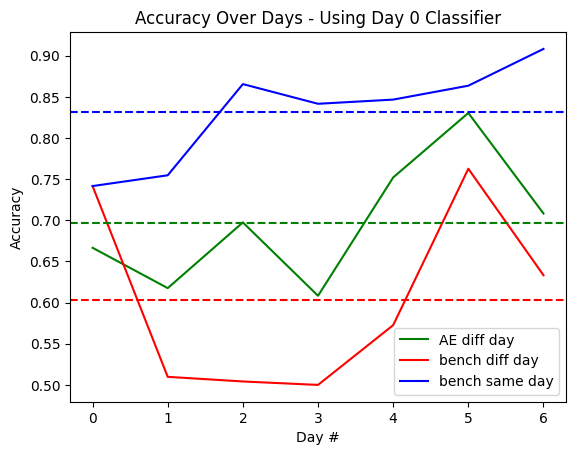

In [34]:
for i in range(len(diff_list)):
    plt.figure(i)
    # Start from which day to plot?
    plot_from = 0
    
    # Plot
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), AE_list[i][plot_from:], label='AE diff day', color='g')
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), diff_list[i][plot_from:], label='bench diff day', color='r')
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), same_list[i][plot_from:], label='bench same day', color='b')

    plt.axhline(y=np.mean(AE_list[i][plot_from:]), color='g', linestyle='--')
    plt.axhline(y=np.mean(diff_list[i][plot_from:]), color='r', linestyle='--')
    plt.axhline(y=np.mean(same_list[i][plot_from:]), color='b', linestyle='--')

    plt.title('Accuracy Over Days - Using Day 0 Classifier')
    plt.xlabel('Day #')
    plt.ylabel('Accuracy')
    plt.legend()
plt.show()

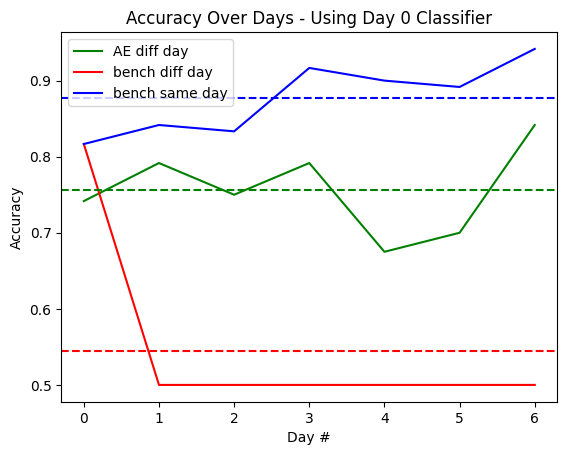

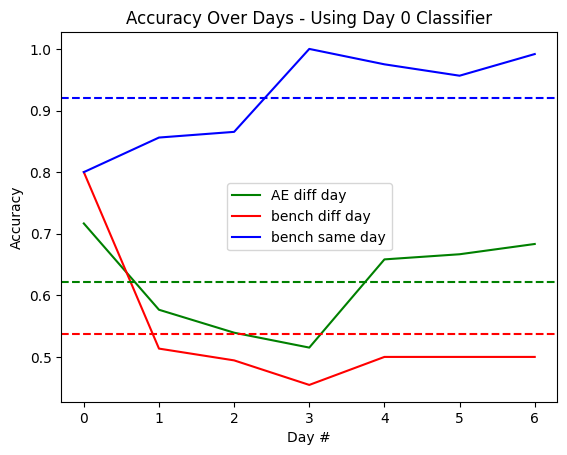

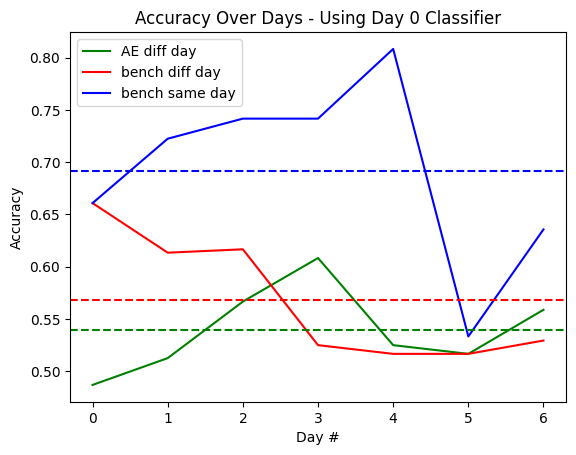

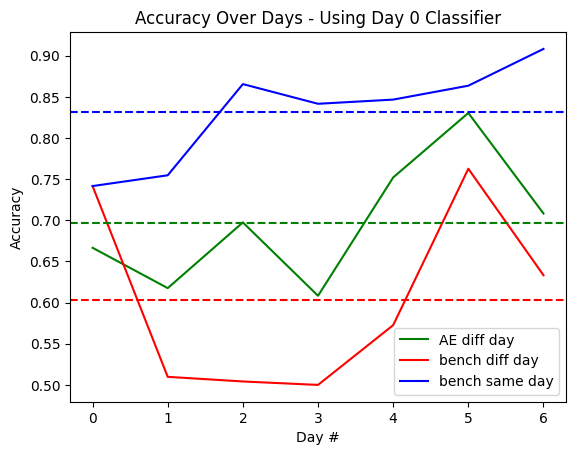

In [35]:
for i in range(len(diff_list)):
    if np.mean(same_list[i]) < 0.55:
        continue
        
    plt.figure(i)
    # Start from which day to plot?
    plot_from = 0
    
    # Plot
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), AE_list[i][plot_from:], label='AE diff day', color='g')
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), diff_list[i][plot_from:], label='bench diff day', color='r')
    plt.plot(range(plot_from, plot_from + len(diff_list[i][plot_from:])), same_list[i][plot_from:], label='bench same day', color='b')

    plt.axhline(y=np.mean(AE_list[i][plot_from:]), color='g', linestyle='--')
    plt.axhline(y=np.mean(diff_list[i][plot_from:]), color='r', linestyle='--')
    plt.axhline(y=np.mean(same_list[i][plot_from:]), color='b', linestyle='--')

    plt.title('Accuracy Over Days - Using Day 0 Classifier')
    plt.xlabel('Day #')
    plt.ylabel('Accuracy')
    plt.legend()
plt.show()